# EDH and LEDH Filter Comparison Demo

This notebook demonstrates and compares two particle flow algorithms:
- **EDH (Exact Daum-Huang)**: Global linearization approach (Algorithm 1)
- **LEDH (Local Exact Daum-Huang)**: Local linearization approach (Algorithm 2)

## 1. Setup and Imports

In [1]:
# --- standard libs ---
import sys
from pathlib import Path

# --- third-party libs ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- project root (for Jupyter) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# --- project imports ---
from edh import EDHFilter
from ekf_ukf_pf.ekf import ExtendedKalmanFilter
from acoustic_function import (
    initialize_acoustic_model,
    simulate_trajectory,
    state_transition,
    observation_model,
    compute_observation_jacobian
)

# --- reproducibility ---
tf.random.set_seed(42)
np.random.seed(42)

# --- environment info ---
print(f"TensorFlow {tf.__version__}")
print(f"GPU available: {bool(tf.config.list_physical_devices('GPU'))}")

TensorFlow 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

# Define state transition and observation functions
state_transition_fn = lambda x: state_transition(
    x, model_params, use_real_noise=False, no_noise=True
)

observation_fn = lambda x: observation_model(
    x, model_params, no_noise=True
)

state_transition_jacobian_fn = lambda x, u=None: model_params["Phi"]

observation_jacobian_fn = lambda x: compute_observation_jacobian(
    x, model_params
)

# Create EKF instance for covariance tracking
ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model_params['Q'],
    R=model_params['R'],
    x0=model_params['x0_initial_target_states'],
    Sigma0=model_params['P0'],
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn,
    use_joseph_form=True
)

print("Model initialized successfully!")
print(f"State dimension: {model_params['x0_initial_target_states'].shape[0]}")
print(f"Observation dimension: {model_params['sensor_positions'].shape[0]}")

Model initialized successfully!
State dimension: 16
Observation dimension: 25


## 3. Generate Ground Truth Data

In [3]:
# Generate ground truth trajectory and measurements
T = 40  # Number of time steps
tf.random.set_seed(42)
print(f"Generating ground truth trajectory ({T} time steps)...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Measurements shape: {measurements.shape}")

Generating ground truth trajectory (40 time steps)...
Ground truth shape: (16, 41)
Measurements shape: (25, 40)


## 4. Run EDH Filter (Global Linearization)

EDH uses global linearization where the observation model is linearized at the particle mean.

In [4]:
# Create EDH filter with global linearization
edh_filter = EDHFilter(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    n_particle=500,      # Number of particles
    n_lambda=29,         # Number of lambda steps
    lambda_ratio=1.2,    # Exponential spacing ratio
    use_local=False,     # Global linearization (Algorithm 1)
    use_ekf=True,        # Use EKF covariance tracking
    ekf_filter=ekf,      # EKF instance
    verbose=True         # Print progress
)

# Run filter on measurements
print("\n" + "="*60)
print("Running EDH Filter (Global Linearization)")
print("="*60)
edh_estimates, edh_particles, edh_covariances = edh_filter.run(
    measurements=measurements,
    model_params=model_params
)

print("\nEDH filter completed!")
print(f"  Estimates shape: {edh_estimates.shape}")
print(f"  Particles shape: {edh_particles.shape}")


Running EDH Filter (Global Linearization)

Running EDH Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (Algorithm 1)
  EKF Covariance: Enabled
  Time steps: 40
  Using provided EKF filter for covariance tracking

Processing time steps...
  Step 10/40
  Step 20/40
  Step 30/40
  Step 40/40

EDH filter completed successfully!
  Estimates shape: (16, 40)
  Particles shape: (16, 500, 40)
  Covariances shape: (16, 16, 40)

EDH filter completed!
  Estimates shape: (16, 40)
  Particles shape: (16, 500, 40)


## 5. Run LEDH Filter (Local Linearization)

LEDH uses local linearization where the observation model is linearized at each particle individually.

In [5]:
# Reinitialize EKF for LEDH
ekf_ledh = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model_params['Q'],
    R=model_params['R'],
    x0=model_params['x0_initial_target_states'],
    Sigma0=model_params['P0'],
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn,
    use_joseph_form=True
)

# Create LEDH filter with local linearization
ledh_filter = EDHFilter(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    n_particle=500,      # Number of particles
    n_lambda=29,         # Number of lambda steps
    lambda_ratio=1.2,    # Exponential spacing ratio
    use_local=True,      # Local linearization (Algorithm 2)
    use_ekf=True,        # Use EKF covariance tracking
    ekf_filter=ekf_ledh,      # Need fresh EKF instance
    verbose=True         # Print progress
)

# Run filter on measurements
print("\n" + "="*60)
print("Running LEDH Filter (Local Linearization)")
print("="*60)
ledh_estimates, ledh_particles, ledh_covariances = ledh_filter.run(
    measurements=measurements,
    model_params=model_params
)

print("\nLEDH filter completed!")
print(f"  Estimates shape: {ledh_estimates.shape}")
print(f"  Particles shape: {ledh_particles.shape}")


Running LEDH Filter (Local Linearization)

Running LEDH Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Local (Algorithm 2)
  EKF Covariance: Enabled
  Time steps: 40
  Using provided EKF filter for covariance tracking

Processing time steps...
  Step 10/40
  Step 20/40
  Step 30/40
  Step 40/40

LEDH filter completed successfully!
  Estimates shape: (16, 40)
  Particles shape: (16, 500, 40)
  Covariances shape: (16, 16, 40)

LEDH filter completed!
  Estimates shape: (16, 40)
  Particles shape: (16, 500, 40)


## 6. Visualize Trajectories Comparison

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_64703/2003164891.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax1.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_64703/2003164891.py:60: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax2.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


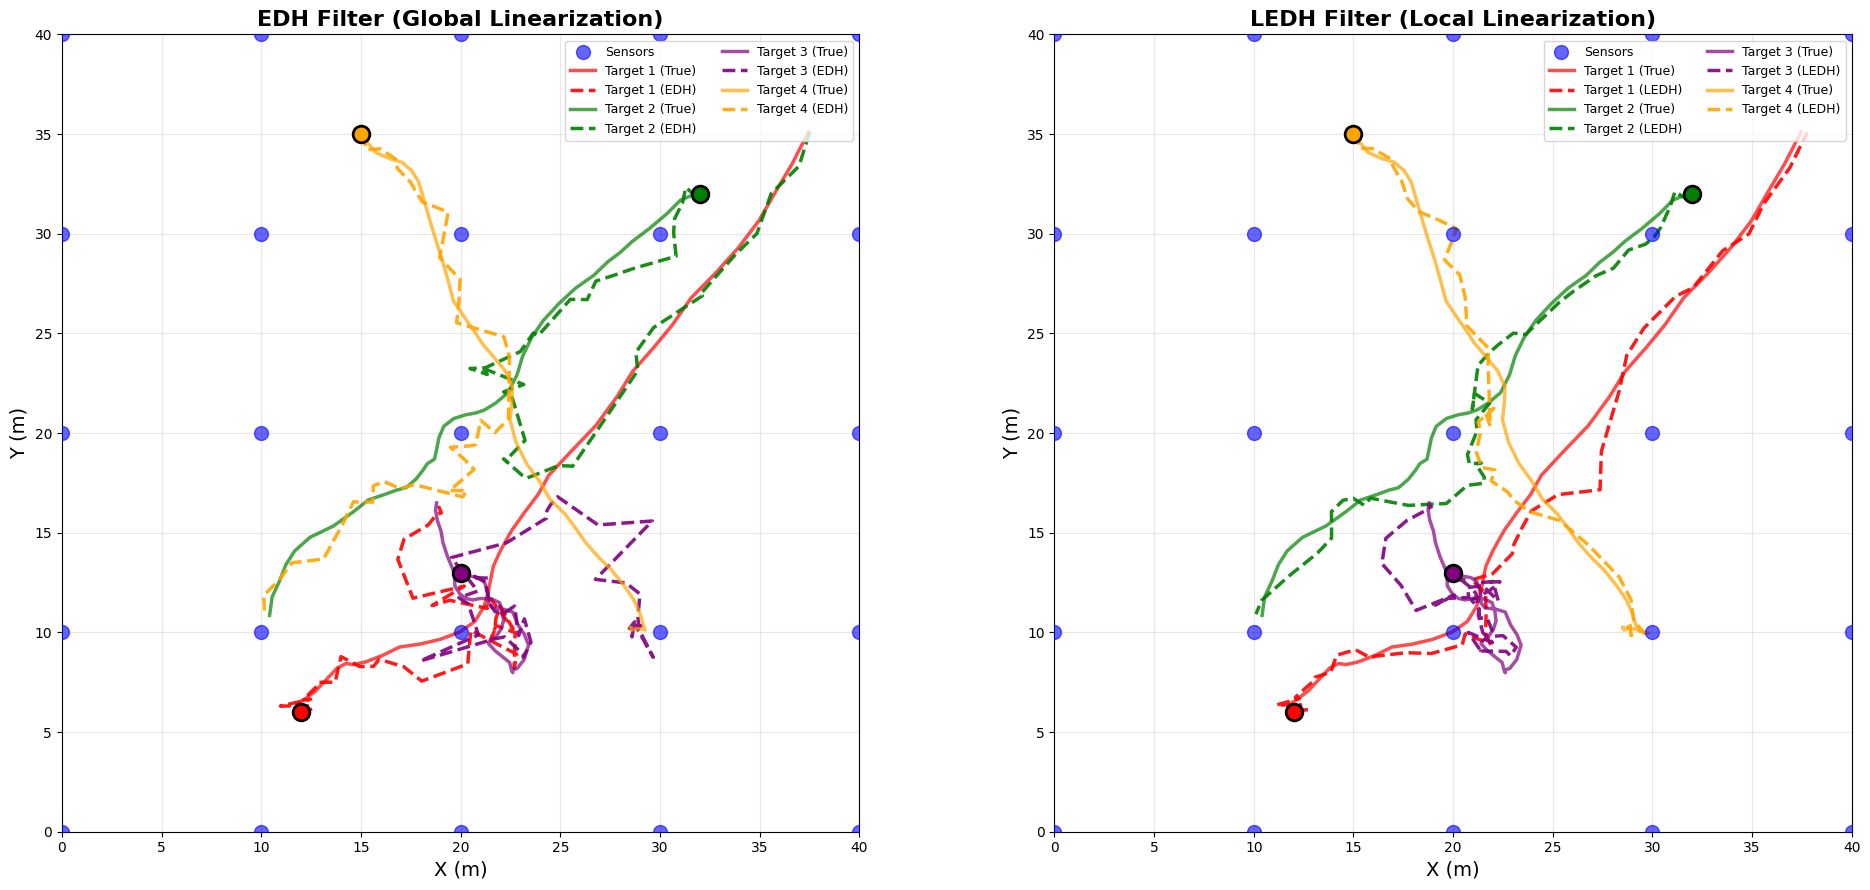

In [6]:
# Plot estimated trajectories for both algorithms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

sensors = model_params['sensor_positions'].numpy()
colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
edh_est = edh_estimates.numpy()
ledh_est = ledh_estimates.numpy()

# EDH Plot
ax1.scatter(sensors[:, 0], sensors[:, 1], 
           c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax1.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
            label=f'Target {i+1} (True)', alpha=0.7)
    
    # EDH Estimates
    x_est = edh_est[x_idx, :]
    y_est = edh_est[y_idx, :]
    ax1.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
            label=f'Target {i+1} (EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax1.plot(x_true[0], y_true[0], 'o', color=colors[i], 
            markersize=12, markeredgecolor='black', markeredgewidth=2)

ax1.set_xlabel('X (m)', fontsize=14)
ax1.set_ylabel('Y (m)', fontsize=14)
ax1.set_title('EDH Filter (Global Linearization)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=9, loc='upper right', ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, model_params['sim_area_size']])
ax1.set_ylim([0, model_params['sim_area_size']])
ax1.set_aspect('equal')

# LEDH Plot
ax2.scatter(sensors[:, 0], sensors[:, 1], 
           c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax2.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
            label=f'Target {i+1} (True)', alpha=0.7)
    
    # LEDH Estimates
    x_est = ledh_est[x_idx, :]
    y_est = ledh_est[y_idx, :]
    ax2.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
            label=f'Target {i+1} (LEDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax2.plot(x_true[0], y_true[0], 'o', color=colors[i], 
            markersize=12, markeredgecolor='black', markeredgewidth=2)

ax2.set_xlabel('X (m)', fontsize=14)
ax2.set_ylabel('Y (m)', fontsize=14)
ax2.set_title('LEDH Filter (Local Linearization)', fontsize=16, fontweight='bold')
ax2.legend(fontsize=9, loc='upper right', ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, model_params['sim_area_size']])
ax2.set_ylim([0, model_params['sim_area_size']])
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

## 7. Visualize Particle Distributions

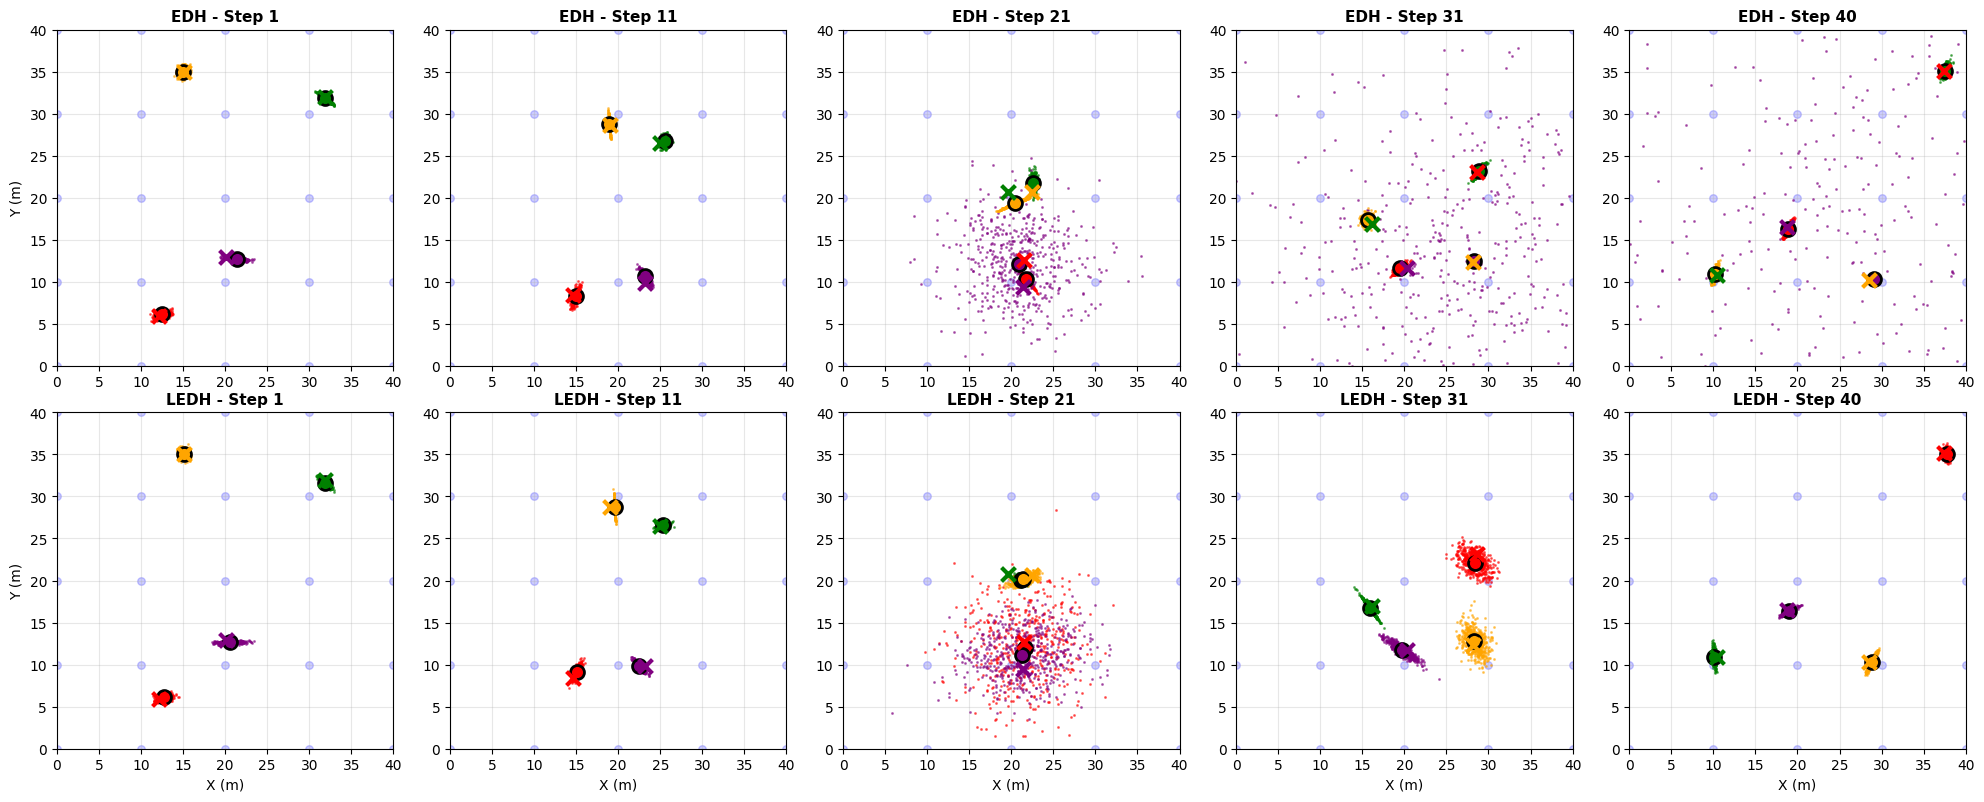

In [7]:
# Compare particle distributions at specific time steps
time_indices = [0, T//4, T//2, 3*T//4, T-1]  # Start, 25%, 50%, 75%, End
fig, axes = plt.subplots(2, len(time_indices), figsize=(20, 8))

colors = ['red', 'green', 'purple', 'orange']
sensors = model_params['sensor_positions'].numpy()

for idx, t in enumerate(time_indices):
    # EDH particles
    ax = axes[0, idx]
    ax.scatter(sensors[:, 0], sensors[:, 1], 
              c='blue', marker='o', s=30, alpha=0.2, zorder=1)
    
    edh_particles_t = edh_particles[:, :, t].numpy()
    
    for i in range(model_params['n_targets']):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        # Particles
        ax.scatter(edh_particles_t[x_idx, :], edh_particles_t[y_idx, :],
                  c=colors[i], marker='.', s=5, alpha=0.5, zorder=2)
        
        # True position
        ax.scatter(gt[x_idx, t+1], gt[y_idx, t+1],
                  c=colors[i], marker='x', s=100, linewidths=3, zorder=4)
        
        # Estimate
        ax.scatter(edh_est[x_idx, t], edh_est[y_idx, t],
                  c=colors[i], marker='o', s=100, 
                  edgecolors='black', linewidths=2, zorder=3)
    
    ax.set_xlim([0, model_params['sim_area_size']])
    ax.set_ylim([0, model_params['sim_area_size']])
    ax.set_aspect('equal')
    ax.set_title(f'EDH - Step {t+1}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.set_ylabel('Y (m)', fontsize=10)
    
    # LEDH particles
    ax = axes[1, idx]
    ax.scatter(sensors[:, 0], sensors[:, 1], 
              c='blue', marker='o', s=30, alpha=0.2, zorder=1)
    
    ledh_particles_t = ledh_particles[:, :, t].numpy()
    
    for i in range(model_params['n_targets']):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        # Particles
        ax.scatter(ledh_particles_t[x_idx, :], ledh_particles_t[y_idx, :],
                  c=colors[i], marker='.', s=5, alpha=0.5, zorder=2)
        
        # True position
        ax.scatter(gt[x_idx, t+1], gt[y_idx, t+1],
                  c=colors[i], marker='x', s=100, linewidths=3, zorder=4)
        
        # Estimate
        ax.scatter(ledh_est[x_idx, t], ledh_est[y_idx, t],
                  c=colors[i], marker='o', s=100, 
                  edgecolors='black', linewidths=2, zorder=3)
    
    ax.set_xlim([0, model_params['sim_area_size']])
    ax.set_ylim([0, model_params['sim_area_size']])
    ax.set_aspect('equal')
    ax.set_title(f'LEDH - Step {t+1}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Y (m)', fontsize=10)

plt.tight_layout()
plt.show()